<b>PyTorch MNIST image classification with Lenet-5 </b>  
* Based on https://github.com/bentrevett/pytorch-image-classification/blob/master/2%20-%20LeNet.ipynb

In [255]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import copy
import random
import time

In [2]:
#set seed for reproduceability
seed = 1234

# python RNG (random number generator)
random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [3]:
#set data dir
ROOT = 'data'

#download MNIST training and test datasets 
train_data = datasets.MNIST(root=ROOT,train=True,download=True)

#data dimension
print(train_data.data.shape)      #torch uint8 datatype with 60000 elements of 28x28 pixels

#calculate mean and std to normalize it to 0-1
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

torch.Size([60000, 28, 28])


In [4]:
#a transformer for input training data
train_transforms = transforms.Compose([
    transforms.RandomRotation(10,fill=(0,)),                     #data aug. rotate by 10 degree
    transforms.RandomCrop(28,padding=5),                         #data aug. crop by 5 pixel (28-5 = 23)
    transforms.ToTensor(),                                       #convert to tensor datatype (matrix)
    transforms.Normalize(mean = [mean],std=[std])                #normailize data using standard score, mean ~0 and std~1
    ])

#a transformer for test data later
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std]) 
    ])

In [5]:
#load the data with transformation
train_data = datasets.MNIST(root = ROOT, 
                            train = True, 
                            download = True, 
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT, 
                           train = False, 
                           download = True, 
                           transform = test_transforms)


In [6]:
#create validation data from training data
VALID_RATIO = 0.9 

#training data size = 90% (54000) of 60000
n_train_examples = int(len(train_data)*VALID_RATIO)

#validation data size =10% (6000) of 60000
n_valid_examples = len(train_data) - n_train_examples

#perform data partitioning on training data
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])


In [7]:
#we want our validation data to be kinda similar to the test set (so no data augmentation)
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms


In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [16]:
#building dataloaders/ iterators (also called generators in other deep learning frameworks)
BATCH_SIZE = 64                 #train on every 64 samples

train_iterator = data.DataLoader(train_data,shuffle=True,batch_size=BATCH_SIZE)      #shuffle training data at each epoch
valid_iterator = data.DataLoader(valid_data,batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data,batch_size=BATCH_SIZE)

Building a ConvNet architecture (CNN)  
* Each convolutional layer has N number of filters 
* For each step, the filter performs a convolution 
* The output of such convolutional layer is the result from that filter
* This result is a feature map (edge, curve, etc.) of the input image  


* The filter moves from left-right and top-bottom at a predefined stride
* A stride = 1 moves the filter by 1 pixel  


* The values of a filtered image (feature map) is defined as : pixel_1 * filter_weight_1 + pixel_1 * filter_weight_2....
* A filter is translationa invariant, which means it will find the object feature no matter where on the image
* A filter's weight is learned via gradient descent and backpropagation  


* More convolutional layers means it can extract more complex image features
* Convolutional layers holds weights (of the filters) and biases --> parameters
* torch.nn.functional.conv2d(tensor,filter) is used for convolution over an image  


* Subsampling layer (a.k.a. pooling layer) reduces the size of input 
* Applied after convolutional layers
* E.g.: max pooling and mean pooling
* Such layer speeds up the model (convolution is computationaly expensive)
* subsampling/ pooling layer does not have parameters (i.e. weights/ biases)
* Max pooling --> extract the most important (or the pixels with the highest brightness)
* pool(tensor,kernel_size) is used for pooling in PyTorch  


* After each convolutional layer (convolution/filtering + max pooling) a ReLu function is used to convert negative values to 0
* A ReLu helps to avoid vanishing gradient (due to negative values)

Building LeNet from scratch
* PyTorch uses class instance to build a a CNN model
* Classic LeNet-5 architecture:
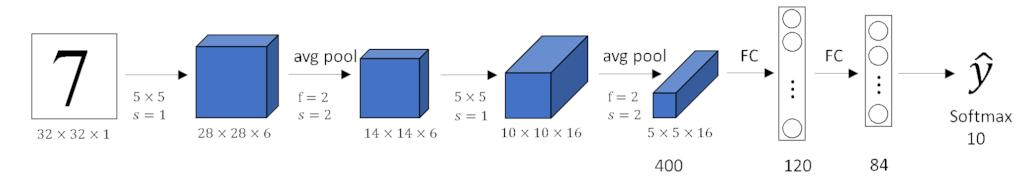

Architecture of our slightly modified LeNet:
* Single channel image as input (28 x 28)
* 5 x 5 x 6 filter with stride = 1 --> ConvLayer 1 (24 x 24 x 6)
* 2 x 2 max pool with stride = 2 --> downsampled image 1 (12 x 12 x 6)
* 5 x 5 x 16 filter with stride = 1 --> ConvLayer 2 (8 x 8 x 16) 
* 2 x 2 max pool with stride = 2 --> downsampled image 2(4 x 4 x 16)
* FC layer 1 
* FC layer 2 
* FC layer 3

In [71]:
class LeNet(nn.Module):
    
    def __init__(self,output_dim):
        #inherit nn.Module
        super().__init__()
        
        #initialize convolution layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5)       
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        
        #initialize fully connected layers (linear functions)
        self.fc_1 = nn.Linear(16 * 4 * 4, 120)               #256 elements to 120
        self.fc_2 = nn.Linear(120, 84)                       #120 elements to 84
        self.fc_3 = nn.Linear(84, output_dim)                #84 elements to 10 classes
        
    #pass a tensor object through the model subsequentely (forward propagation)
    def forward (self,x):
        #input input image = x = (batch size, 1, 28, 28)   
        
        x = self.conv1(x)                        #apply convolution 1 -->out [batch_size,6,24,24]
        x = F.max_pool2d(x, kernel_size = 2)     #apply max pool 1 --> out [batch_size,6,12,12]
        x = F.relu(x)                            #apply reLu
        
        x = self.conv2(x)                        #apply convolution 2
        x = F.max_pool2d(x,kernel_size=2)        #apply max pool 2
        x = F.relu(x)                            #apply ReLu              image dimension = [batch_size,16,4,4]
        
        x = x.view(x.shape[0],-1)                #returns a tensor vector with dimension: [batch_size,16*4*4]
        h = x                                    #assign tensor vector to a new variable
        
        x = self.fc_1(x)                         # apply fc 1
        x = F.relu(x)                            # apply ReLu
        x = self.fc_2(x)                         # apply fc 2
        x = F.relu(x)                            # apply Relu
        x = self.fc_3(x)                         # apply fc 1
        
        return x,h                               #returns the classification and tensor vector [batch_size,output_dim]

Use the LeNet model
* MNIST dataset has 10 classes/ labels = 0,1,2....9

In [19]:
#instantiate the LeNet model with 10 expected output (= 10 classes)
OUTPUT_DIM = 10
model = LeNet(10)
print(model)

nr_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print('nr params:',nr_params)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)
nr params: 44426


* Gradient is a vector which gives us the direction in which loss function has the steepest ascent.
* requires_grad == True means that the weights are yet to be set (through training)
* An optimizer will hold current state and update the parameters based on the computed gradients.
* loss function/ cost function is a function that penalize error (hence we want to minmimize errors as much as possible)
     * CrossEntropyLoss() criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

In [20]:
#define optimizer based on parameters
optimizer = optim.Adam(model.parameters())

#define loss function (will also apply softmax activation function)
#cross entropy will awards lower loss value (i.e. close to 0)
criterion = nn.CrossEntropyLoss()

#put (allocate) model and data on the GPU/CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [223]:
#function to calculate accuracy 
def calculate_accuracy(y_pred, y):
    labels_pred = y_pred.max(1)[1]            #get the labels (indices) with max values from the column (axis=1)
    correct = sum(labels_pred == y).float()   #sum correct values 
    acc = correct.float() / y.shape[0]
    return acc

In [222]:
#function to train the model 
def train(model,iterator,optimizer,criterion,device):
    
    #update accuracy and loss scores
    epoch_loss = 0
    epoch_acc = 0
    
    #set model to train
    model.train()
    
    for (x, y) in iterator:
        #allocate x variable and y label to GPU/ CPU
        x = x.to(device)                  #input images with dimension: [batch_size,nr_channel,height,widht]
        y = y.to(device)                  #input labels(= ineteger) with dimension: [batch_size]
        
        optimizer.zero_grad()             #clears old gradients from the last step
        
        y_pred, _ = model(x)                  #predict output
        acc = calculate_accuracy(y_pred, y)  #calculate accuracy (based on validation set)
        
        #optimize model by reducing loss (gradient descent)
        loss = criterion(y_pred, y)       #calculate loss 
        loss.backward()                   #computes the derivative of the loss w.r.t (weights) (gradient loss)
        optimizer.step()                  #make optimizer to take a step based on the calculate gradients of the parameters
        
        #store loss and accuracy scores
        epoch_loss += loss.item()         #increment loss score      
        epoch_acc += acc.item()           #increment accuracy score
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

After training we would liek to evaluate its accuracy on unseed data (test data)
* torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed up computations but you won’t be able to backprop (which you don’t want in an eval script)

In [23]:
#function to evaluate for each test data
# notice there is no optimiziation steps here
def evaluate(model,iterator,criterion,device):
    epoch_loss = 0
    epoch_acc = 0
    
    #set model on evaluation
    model.eval()
    
    with torch.no_grad():
        
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            
            y_pred,_ = model(x)
            loss = criterion(y_pred,y)
            acc = calculate_accuracy(y_pred,y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

We would like to record how long the model takes to train at each iteration/ epoch 

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training time!

In [227]:
#set number of iteration
EPOCHS = 20

#update best validation loss score
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.time()
    train_loss,train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    
    if valid_loss<best_valid_loss:
        best_valid_loss = valid_loss
        #export/rewrite the model (i.e. weights and biases) if there is improvement in the model
        torch.save(model.state_dict(),'./model/tut2-model.pt')
        
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 20s
	Train Loss: 0.239 | Train Acc: 92.52%
	 Val. Loss: 0.177 |  Val. Acc: 94.85%
Epoch: 02 | Epoch Time: 0m 20s
	Train Loss: 0.198 | Train Acc: 93.78%
	 Val. Loss: 0.129 |  Val. Acc: 96.05%
Epoch: 03 | Epoch Time: 0m 20s
	Train Loss: 0.174 | Train Acc: 94.54%
	 Val. Loss: 0.106 |  Val. Acc: 96.78%
Epoch: 04 | Epoch Time: 0m 20s
	Train Loss: 0.151 | Train Acc: 95.26%
	 Val. Loss: 0.116 |  Val. Acc: 96.48%
Epoch: 05 | Epoch Time: 0m 20s
	Train Loss: 0.140 | Train Acc: 95.66%
	 Val. Loss: 0.087 |  Val. Acc: 97.27%
Epoch: 06 | Epoch Time: 0m 20s
	Train Loss: 0.128 | Train Acc: 95.98%
	 Val. Loss: 0.075 |  Val. Acc: 97.68%
Epoch: 07 | Epoch Time: 0m 20s
	Train Loss: 0.124 | Train Acc: 96.09%
	 Val. Loss: 0.075 |  Val. Acc: 97.52%
Epoch: 08 | Epoch Time: 0m 20s
	Train Loss: 0.114 | Train Acc: 96.49%
	 Val. Loss: 0.091 |  Val. Acc: 97.33%
Epoch: 09 | Epoch Time: 0m 20s
	Train Loss: 0.112 | Train Acc: 96.50%
	 Val. Loss: 0.074 |  Val. Acc: 97.73%
Epoch: 10 | Epoch T

In [231]:
#open model with the best parameters and evalute test dataset
model.load_state_dict(torch.load('./model/tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.037 | Test Acc: 98.80%


Examine model through PCA and t-SNE

In [236]:
def get_predictions(model,iterator,device):
    
    model.eval()
    
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y_pred,_ = model(x)
            y_prob = F.softmax(y_pred,dim=-1)       #determine probabilities of multiple classes with softmax
            
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
            
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [263]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = probs.max(1)[1] 

#plot confusion matrix (ground truth = rows, predicted labels = columns)
pd.crosstab(labels.numpy(),pred_labels.numpy())

col_0    0     1     2    3    4    5    6     7    8    9
row_0                                                     
0      972     0     1    0    1    1    5     0    0    0
1        0  1131     1    0    0    0    1     2    0    0
2        1     0  1023    2    0    1    0     4    1    0
3        0     0     2  998    0    8    0     1    0    1
4        0     0     0    0  962    0    6     3    0   11
5        0     0     1    3    0  887    1     0    0    0
6        3     1     0    0    0    4  949     0    1    0
7        0     2     5    2    0    0    0  1014    1    4
8        0     0     4    0    0    2    1     2  962    3
9        1     0     0    2    6   10    0     5    3  982

Based on the confusion matrix we can infer that 4,9, 7 and 2 are often missclassified

In [271]:
#get correct samples
corrects = labels == pred_labels

incorrect_examples = [(image,label,prob) for image, label, prob, correct in zip(images, labels, probs, corrects) if not correct ]

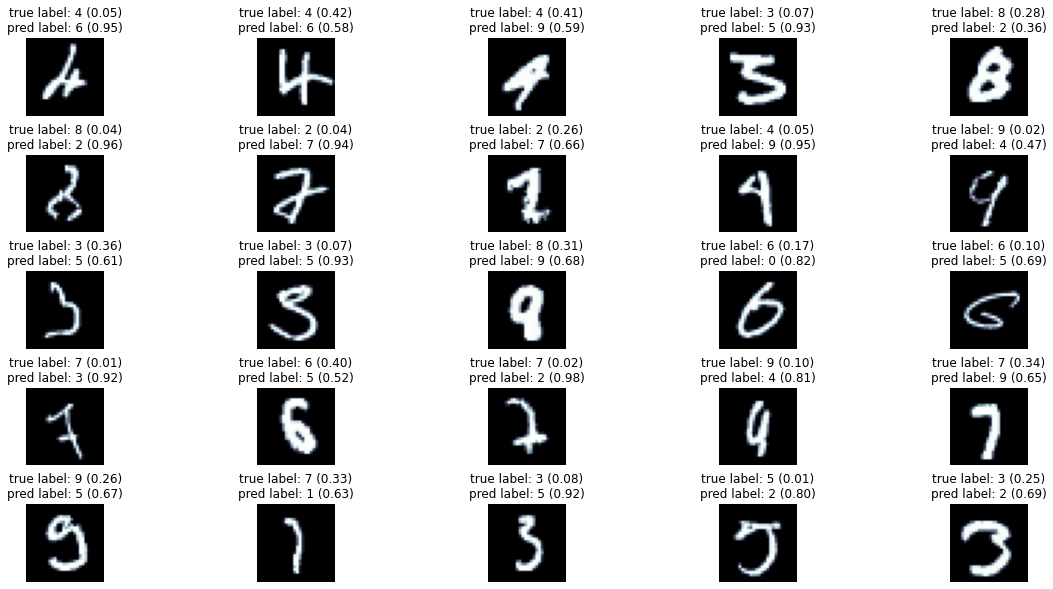

In [281]:
#plost most incorrect images
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.2f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.2f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)

In [282]:
#get representaiton from the model
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y.cpu())
        
    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, intermediates, labels

In [287]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)

A PCA plot of the output data shows how the data is clustered

In [284]:
#function to create PCA
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [285]:
#function to plot the PCA results
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    legend = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend)

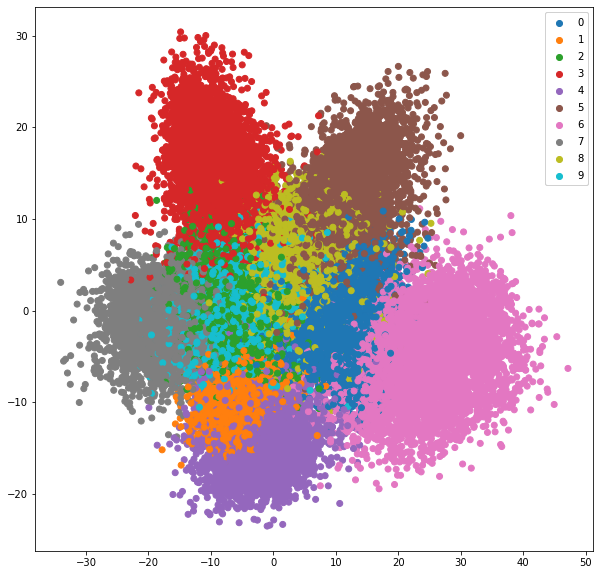

In [291]:
#get PCA data and plot PC1 and PC2 on the x and y aces respectively
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

The intermediate data shows the data just after the 2nd convolutional and pooling layers
* The plot shows that many of the labels are overlapping
* This is because only the features are extracted
* The subsequent linear layers (fully connected layers) will weight these features for prediction
* Notice that number 1 is quite clustered already in the intermediate data, because its much easier to recognise

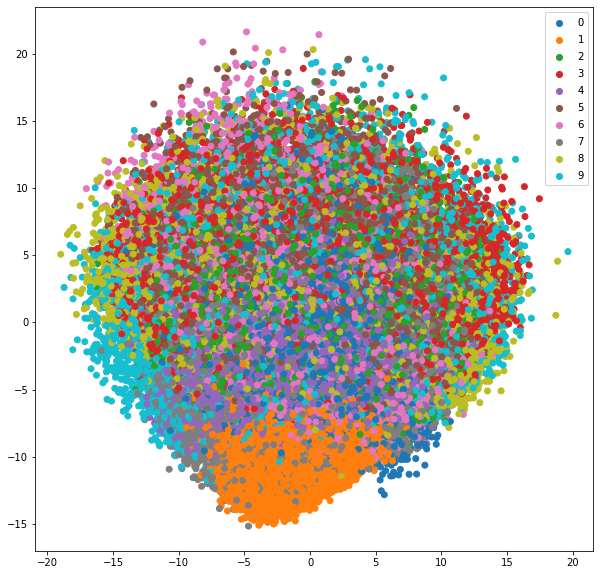

In [296]:
#plot the intermediate  data
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

A t-SNE (t-Distributed Stochastic Neighbor Embedding) is another method to visualize high 
dimensionality data

In [299]:
#function to calculate t-SNE
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

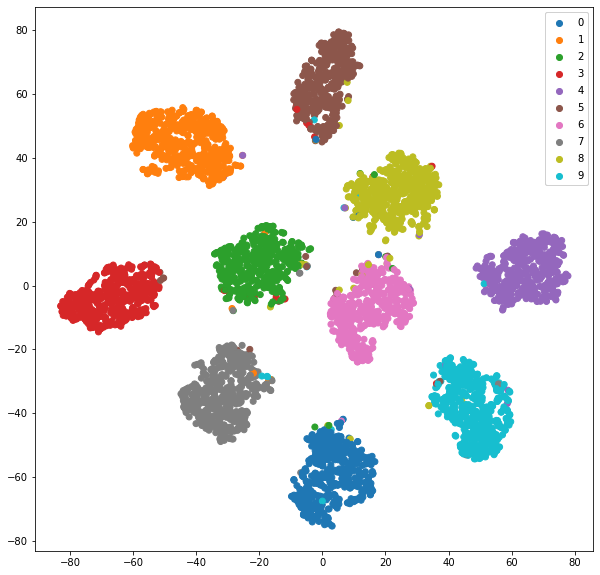

In [302]:
#plot the cluster of each label for the first 5000 images
N_IMAGES = 5000
output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)

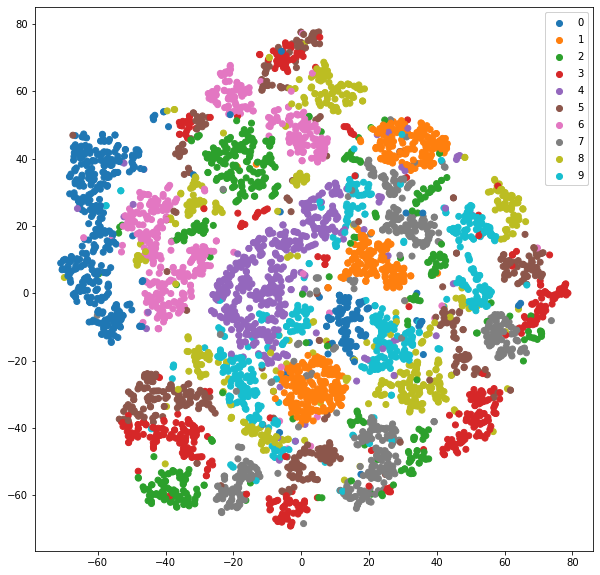

In [303]:
#plot the t-SNE of the intermediate data
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)

* Compared with the PCA plot based on the output data the t-SNE method is able to seperate the classes visually.  
* This is also true for the intermediate data.  
* Nonetheless, a t-SNE provides visual insight about the model and evaluate how well it learns the input data

Adversial example is a flaw of most neural networks. The demo below shows a random noise that is predicted as 3

In [305]:
#function to calculate the best image and probabily based on any given digit
def imagine_digit(model, digit, device, n_iterations = 50000):

    model.eval()
    
    best_prob = 0
    best_image = None

    with torch.no_grad():
    
        for _ in range(n_iterations):
            
            #random noisy image
            x = torch.randn(32, 1, 28, 28).to(device)
            
            #predict noisy image
            y_pred, _ = model(x)
            preds = F.softmax(y_pred, dim = -1)
            
            #get the highest prob and its index for a given digit
            _best_prob, index = torch.max(preds[:,digit], dim = 0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

In [306]:
#get best image and probability for digit = 3
DIGIT = 3
best_image, best_prob = imagine_digit(model, DIGIT, device)

Prob. of digit equals 3: 0.9953137636184692


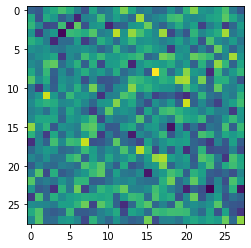

In [322]:
print('Prob. of digit equals 3:',best_prob.item())
plt.imshow(best_image.squeeze(0).cpu());

Demo of how the computes filters weights work on the images
* model.conv1.weight.data contains the filter of the first convolutional layer
* model.conv2.weight.data contains the filter of the second convolutional layer

In [329]:
#function to plot filtered images
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

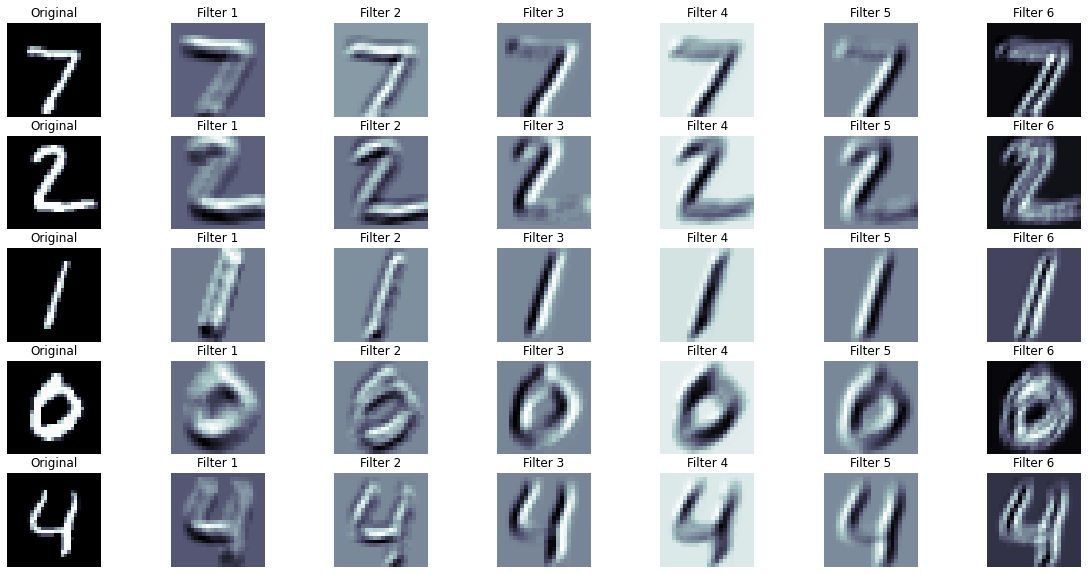

In [341]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

filtered_images = plot_filtered_images(images, filters)

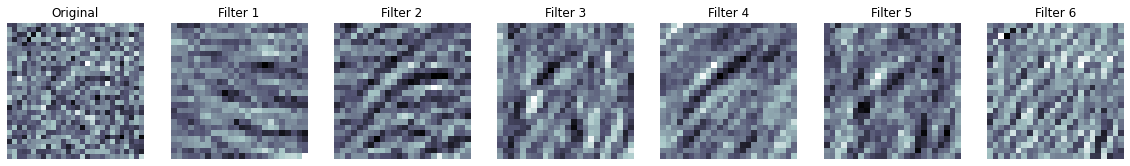

In [343]:
plot_filtered_images([best_image], filters)